### Tiny ImageNet 데이터셋 로드

In [1]:
import zipfile
import urllib.request
import os

# Tiny ImageNet 데이터 다운로드 및 압축 해제
url = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
output_path = 'tiny-imagenet-200.zip'
urllib.request.urlretrieve(url, output_path)

with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall('tiny-imagenet-200')

# Tiny ImageNet 경로 설정
train_dir = '/content/tiny-imagenet-200/tiny-imagenet-200/train'
val_dir = '/content/tiny-imagenet-200/tiny-imagenet-200/val'

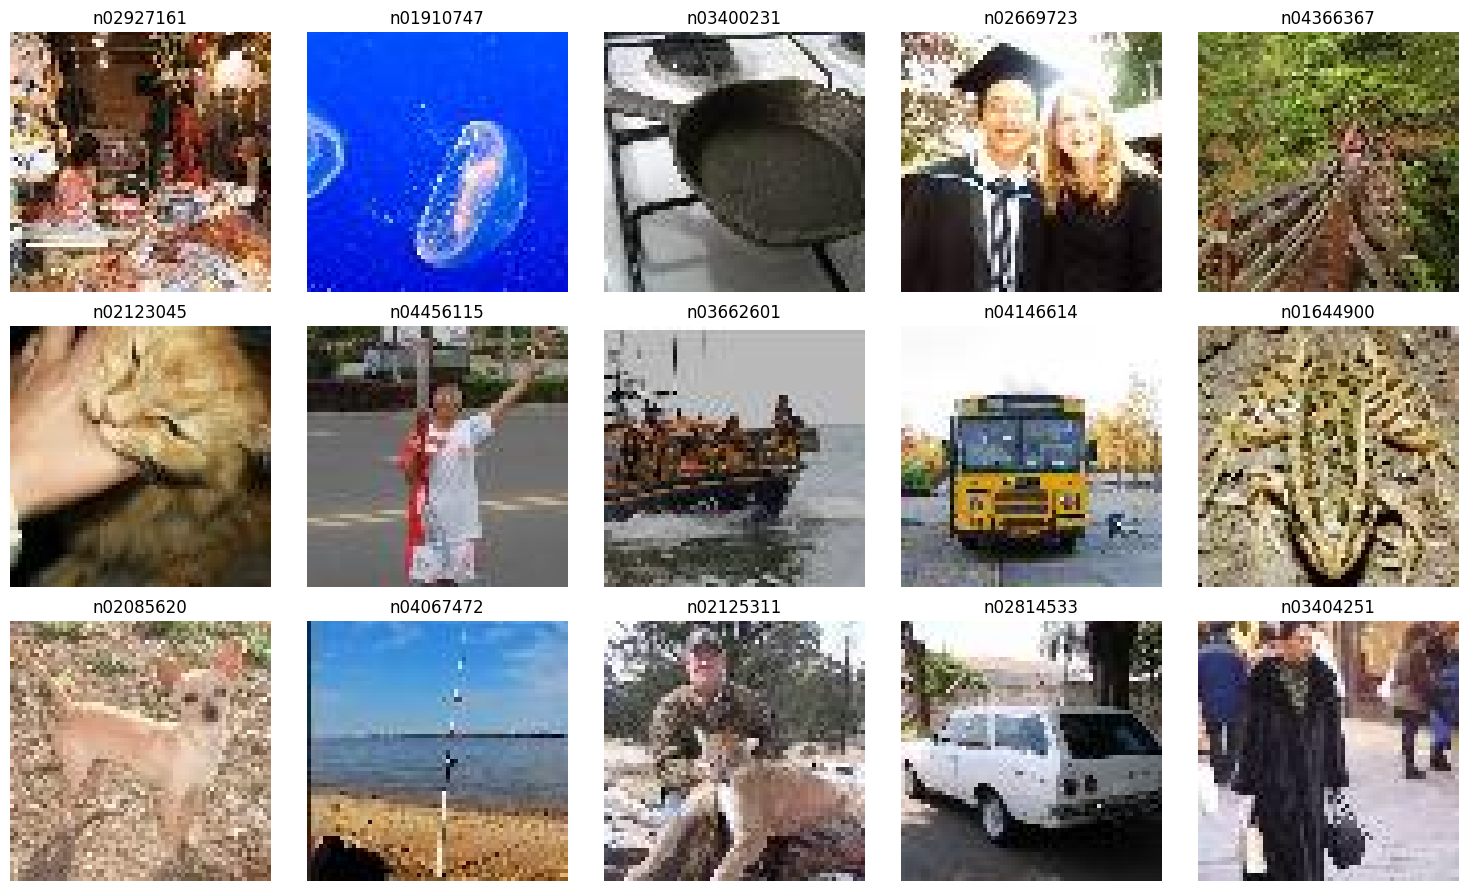

In [2]:
import matplotlib.pyplot as plt
import random
from PIL import Image

class_dirs = [os.path.join(train_dir, class_dir) for class_dir in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, class_dir))]

images = []
labels = []

for class_dir in class_dirs:
    class_name = os.path.basename(class_dir)
    image_dir = os.path.join(class_dir, 'images')
    image_files = os.listdir(image_dir)

    random_image = random.choice(image_files)
    images.append(os.path.join(image_dir, random_image))
    labels.append(class_name)

    if len(images) == 15:
        break

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.ravel()

for i in range(15):
    img = Image.open(images[i])
    axes[i].imshow(img)
    axes[i].set_title(labels[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Tiny ImageNet 검증 데이터 재구성

In [3]:
import os
import shutil

# 검증 데이터 디렉토리 설정
val_dir = '/content/tiny-imagenet-200/tiny-imagenet-200/val'
val_annotations_path = os.path.join(val_dir, 'val_annotations.txt')

# 검증 이미지를 클래스별 폴더로 분류
val_img_dir = os.path.join(val_dir, 'images')
val_labels_dir = os.path.join(val_dir, 'organized')

if not os.path.exists(val_labels_dir):
    os.makedirs(val_labels_dir)

# val_annotations.txt에서 이미지 파일과 라벨을 읽어와서 각 클래스 폴더로 이동
with open(val_annotations_path, 'r') as f:
    for line in f:
        parts = line.strip().split('\t')
        img_file = parts[0]
        class_label = parts[1]

        class_dir = os.path.join(val_labels_dir, class_label)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)

        # 이미지를 해당 클래스 폴더로 복사
        shutil.move(os.path.join(val_img_dir, img_file), os.path.join(class_dir, img_file))

### 데이터 증강

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 이미지 크기와 배치 사이즈 설정
IMG_SIZE = (64, 64)  # Tiny ImageNet 이미지는 64x64 크기
BATCH_SIZE = 32

# 데이터 증강
# train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2,
#                                    height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


# 학습 및 검증 데이터 로드
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                                    class_mode='categorical')
val_generator = val_datagen.flow_from_directory(os.path.join(val_dir, 'organized'),
                                                target_size=IMG_SIZE, batch_size=BATCH_SIZE,
                                                class_mode='categorical')

---
### 1차 모델링
- 사전 훈련 층 모두 고정

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

# VGG16 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# 새로운 분류 레이어 추가
x = base_model.output
x = Flatten()(x)  # 평탄화
x = Dense(512, activation='relu')(x)  # 완전 연결층
predictions = Dense(200, activation='softmax')(x)  # Tiny ImageNet은 200개의 클래스

# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 사전 훈련된 층 모두 고정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 구조 확인
model.summary()

# 모델 학습
history = model.fit(train_generator, epochs=10, validation_data=val_generator, verbose=1)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,866,376 (60.53 MB)

 Trainable params: 1,151,688 (4.39 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 211s 67ms/step - accuracy: 0.1019 - loss: 4.3182 - val_accuracy: 0.2280 - val_loss: 3.4133
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 256s 65ms/step - accuracy: 0.2071 - loss: 3.5573 - val_accuracy: 0.2522 - val_loss: 3.2797
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 266s 66ms/step - accuracy: 0.2302 - loss: 3.4323 - val_accuracy: 0.2566 - val_loss: 3.2288
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 208s 66ms/step - accuracy: 0.2398 - loss: 3.3718 - val_accuracy: 0.2759 - val_loss: 3.1841
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 257s 65ms/step - accuracy: 0.2477 - loss: 3.3387 - val_accuracy: 0.2728 - val_loss: 3.1523
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 268s 67ms/step - accuracy: 0.2511 - loss: 3.2911 - val_accuracy: 0.2703 - val_loss: 3.1668
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 262s 67ms/step - accuracy: 0.2565 - loss: 3.2724 - val_accuracy: 0.2844 - val_loss: 3.1401
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 209s 67ms/step - accuracy: 

### 1차 모델링 결과

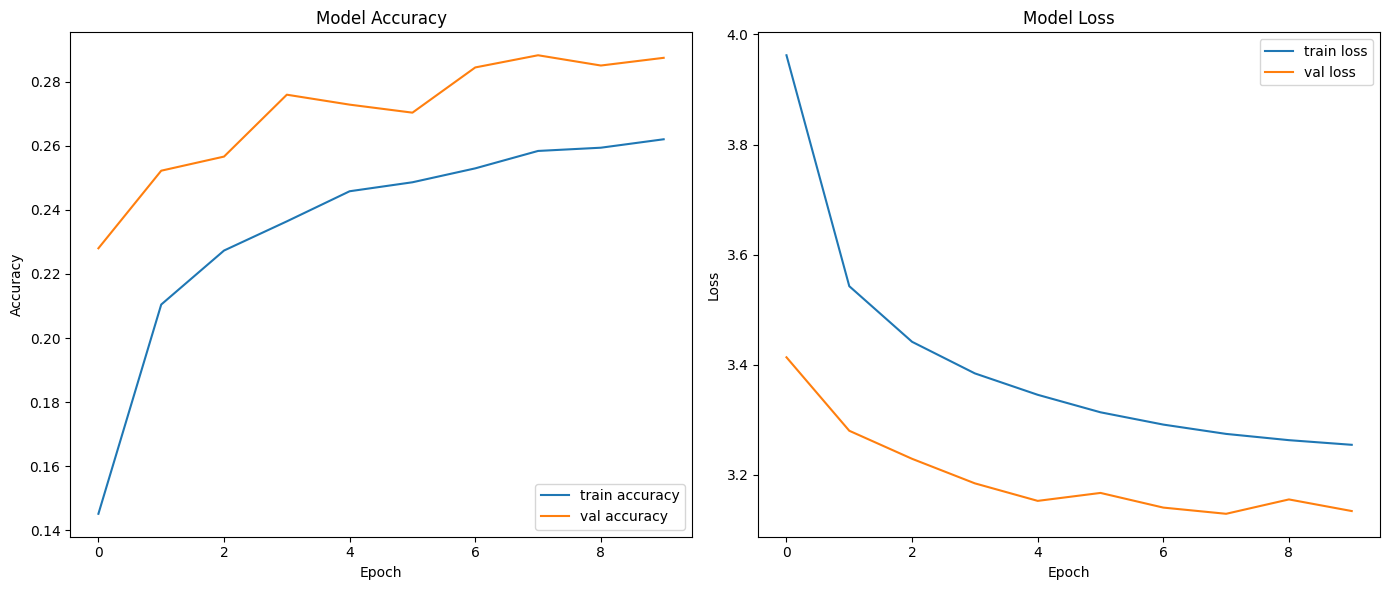

In [21]:
# 학습 정확도 및 손실 시각화
import matplotlib.pyplot as plt

def plot_training_history(history):

    plt.figure(figsize=(14, 6))

    # 정확도
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Model Accuracy')

    # 손실
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title('Model Loss')

    # 레이아웃 자동 조정 및 출력
    plt.tight_layout()
    plt.show()
    print()

plot_training_history(history)

In [20]:
# 학습 데이터 평가
train_loss, train_acc = model.evaluate(train_generator)

# 검증 데이터 평가
test_loss, test_acc = model.evaluate(val_generator)

print()
print("=====================================")
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")
print("-------------------------------------")
print(f"Validation Loss: {test_loss}")
print(f"Validation Accuracy: {test_acc}")
print("=====================================")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 204s 65ms/step - accuracy: 0.2710 - loss: 3.1800
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.2831 - loss: 3.1303

Train Loss: 3.173232078552246
Train Accuracy: 0.27241000533103943
-------------------------------------
Validation Loss: 3.133826494216919
Validation Accuracy: 0.2874000072479248



---
### 2차 모델링
- 사전 훈련 층 중 12개 층 학습
- 학습률 조정
- Epoch 수 추가
- Early Stopping 적용

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# VGG16 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# 새로운 분류 레이어 추가
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(200, activation='softmax')(x)

# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 마지막 12개 층을 학습 가능하게 설정
for layer in base_model.layers[:-12]:
    layer.trainable = False
for layer in base_model.layers[-12:]:
    layer.trainable = True

# 모델 컴파일
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 모델 구조 확인
model.summary()

# EarlyStopping 콜백 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(train_generator, epochs=20, validation_data=val_generator, verbose=1,
                    callbacks=[early_stopping])

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,866,376 (60.53 MB)

 Trainable params: 15,606,216 (59.53 MB)

 Non-trainable params: 260,160 (1016.25 KB)

Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 239s 74ms/step - accuracy: 0.0672 - loss: 4.7344 - val_accuracy: 0.2527 - val_loss: 3.3347
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 264s 76ms/step - accuracy: 0.2800 - loss: 3.1450 - val_accuracy: 0.3296 - val_loss: 2.9186
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 259s 75ms/step - accuracy: 0.3626 - loss: 2.7128 - val_accuracy: 0.3832 - val_loss: 2.6464
Epoch 4/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 242s 77ms/step - accuracy: 0.4112 - loss: 2.4744 - val_accuracy: 0.4308 - val_loss: 2.3952
Epoch 5/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 256s 76ms/step - accuracy: 0.4468 - loss: 2.2962 - val_accuracy: 0.4384 - val_loss: 2.3732
Epoch 6/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 256s 74ms/step - accuracy: 0.4740 - loss: 2.1570 - val_accuracy: 0.4431 - val_loss: 2.3828
Epoch 7/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 266s 75ms/step - accuracy: 0.4954 - loss: 2.0505 - val_accuracy: 0.4757 - val_loss: 2.2013
Epoch 8/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 233s 74ms/step - accuracy: 

### 2차 모델링 결과

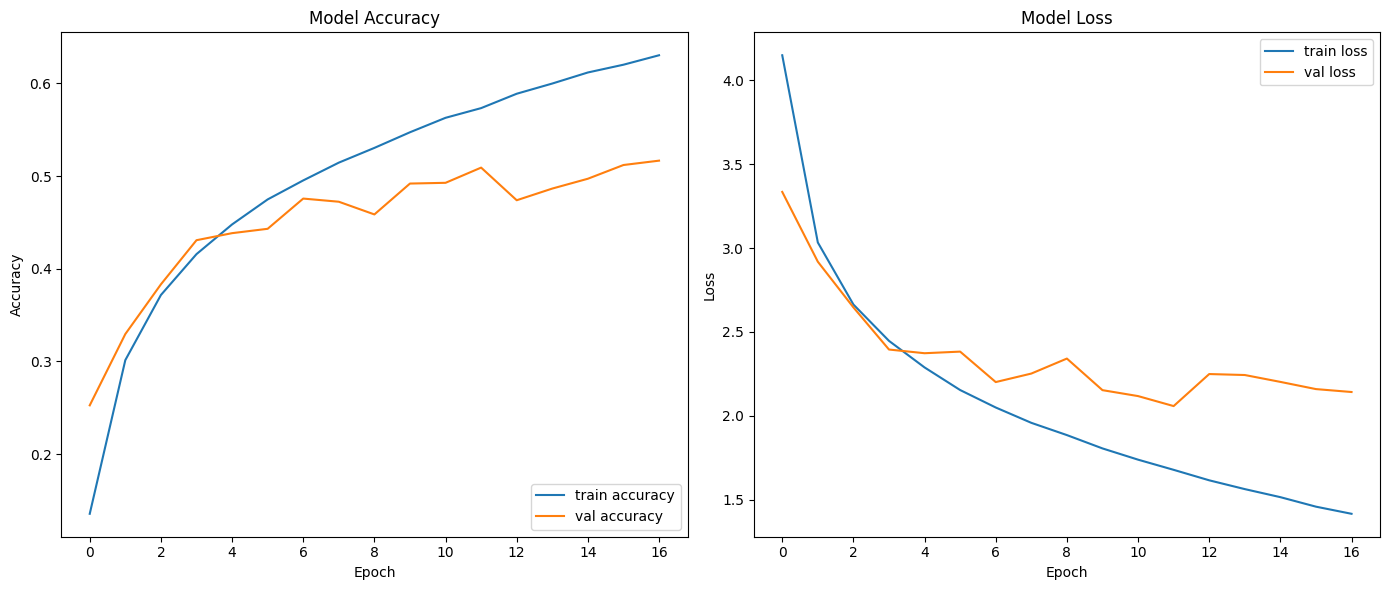

In [24]:
plot_training_history(history)

In [25]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(val_generator)

print()
print("=====================================")
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")
print("-------------------------------------")
print(f"Validation Loss: {test_loss}")
print(f"Validation Accuracy: {test_acc}")
print("=====================================")

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 199s 64ms/step - accuracy: 0.5980 - loss: 1.5795
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5057 - loss: 2.0516

Train Loss: 1.5792118310928345
Train Accuracy: 0.5983899831771851
-------------------------------------
Validation Loss: 2.058173894882202
Validation Accuracy: 0.5091000199317932


---
### 3차 모델링
- 사전 훈련 층 모두 학습
- 학습률 재조정

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# VGG16 모델 로드
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# 새로운 분류 레이어 추가
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(200, activation='softmax')(x)

# 최종 모델 구성
model = Model(inputs=base_model.input, outputs=predictions)

# 사전 훈련된 층 모두 학습
for layer in base_model.layers:
    layer.trainable = True

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 모델 구조 확인
model.summary()

# EarlyStopping 콜백 추가
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(train_generator, epochs=20, validation_data=val_generator, verbose=1,
                    callbacks=[early_stopping])

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 64, 64, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 16, 16, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 4, 4, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 2, 2, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 15,866,376 (60.53 MB)

 Trainable params: 15,866,376 (60.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 260s 80ms/step - accuracy: 0.0048 - loss: 5.3109 - val_accuracy: 0.0050 - val_loss: 5.2984
Epoch 2/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 253s 79ms/step - accuracy: 0.0042 - loss: 5.2990 - val_accuracy: 0.0050 - val_loss: 5.2984
Epoch 3/20
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 246s 79ms/step - accuracy: 0.0047 - loss: 5.2990 - val_accuracy: 0.0050 - val_loss: 5.2984
Epoch 4/20
1026/3125 ━━━━━━━━━━━━━━━━━━━━ 2:41 77ms/step - accuracy: 0.0049 - loss: 5.2986

### 3차 모델링 결과

In [ ]:
plot_training_history(history)

In [ ]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(val_generator)

print()
print("=====================================")
print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_acc}")
print("-------------------------------------")
print(f"Validation Loss: {test_loss}")
print(f"Validation Accuracy: {test_acc}")
print("=====================================")